# Anomaly Detection in Networks via Score-Based Generative Models

[Paper](https://arxiv.org/abs/2306.15324) | [Github](https://github.com/realfolkcode/GraphDiffusionAnomaly)

This notebook demonstrates how our paper can be reproduced. First, GDSS models are trained with randomly chosen hyperparameters. It uses *shift in energy* as a dissimilarity measure to calculate anomaly scores.

**Remark:** We recommend to run this notebook in Google Colab. To run it locally, modify/append the paths to import our modules and do not clone the repository in the Setup section.

## Setup

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=9d99d033b3913aaf4bd52872b5047f17e6d77a1287a4a54bf4cc9ffb77ffb8a7
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 50.9 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/realfolkcode/GraphDiffusionAnomaly

Cloning into 'GraphDiffusionAnomaly'...
remote: Enumerating objects: 1412, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 1412 (delta 322), reused 263 (delta 216), pack-reused 1019
Receiving objects: 100% (1412/1412), 33.45 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (951/951), done.


In [ ]:
%cd GraphDiffusionAnomaly/

/content/GraphDiffusionAnomaly


In [ ]:
!python -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygod: filename=pygod-0.4.0-py3-none-any.whl size=70393 sha256=8b8d4d0501479a4e120d982bcce3f5270ce7da6904a195a9cc03c08dad664ff8
  Stored in directory: /root/.cache/pip/wheels/21/1a/7e/5cd9ae4615761d1fc722627ac83e167b41a551a0e44435394a
Successfully built pygod


## Training and Inference

Restart the runtime

In [ ]:
%cd GraphDiffusionAnomaly

/content/GraphDiffusionAnomaly


Let us run the benchmark on the Disney dataset. To do this, we choose the corresponding config file and name our experiment (`exp_name`) after the dataset (checkpoints will be named accordingly).

In [ ]:
!python run_benchmark.py --config GDSS/config/disney.yaml --exp_name disney --is_energy True --trajectory_sample 4 --num_sample 3 --radius 1

100% 124/124 [00:00<00:00, 506.87it/s]
Dataset: disney
Number of nodes: 124
Running experiment no. 0
Max size subgraphs (95% quantile): 12
Feature dimension: 28
----------------------------------------------------------------------------------------------------
Make Directory disney/test in Logs
disney_0
----------------------------------------------------------------------------------------------------
[disney]   init=deg (28)   seed=0   batch_size=124
----------------------------------------------------------------------------------------------------
lr=0.01 schedule=False ema=0.999 epochs=300 reduce=False eps=1e-05
(ScoreNetworkX)+(ScoreNetworkA=GCN,4)   : depth=1 adim=16 nhid=32 layers=1 linears=2 c=(2 8 4)
(x:VP)=(0.10, 1.00) N=1000 (adj:VP)=(0.10, 1.00) N=1000
----------------------------------------------------------------------------------------------------

[Epoch]:   0% 0/300 [00:00<?, ?it/s]
[Epoch]:   0% 1/300 [00:00<04:39,  1.07it/s]
[Epoch]:   1% 3/300 [00:01<01:26,  3.43

## Evaluation

In [ ]:
import numpy as np
import torch
import pygod
from pygod.utils import load_data
from pygod.metric.metric import *

import matplotlib.pyplot as plt

from utils import calculate_snr
from GDSS.parsers.config import get_config

In [ ]:
dataset_name = 'disney'

y = load_data(dataset_name).y.bool()
k = sum(y)

In [ ]:
exp_name = f'{dataset_name}'

Unweighted anomaly scores

In [ ]:
auc, ap, rec = [], [], []
E_rec_lst = []
X_norm_rec_lst = []

for i in range(20):
    with open(f'{exp_name}_{i}_final_scores.npy', 'rb') as f:
        E_orig = np.load(f)[:, None, None]
        E_rec = np.load(f)
        X_norm_orig = np.load(f)[:, None, None]
        X_norm_rec = np.load(f)

    E_rec_lst.append(E_rec)
    X_norm_rec_lst.append(X_norm_rec)
    score = np.abs(E_orig / (X_norm_orig**2 + 1e-9) - E_rec / (X_norm_rec**2 + 1e-9))
    score = score.mean(1)
    score = score.mean(-1)
    score = np.nan_to_num(score)
    score = torch.tensor(score)

    auc.append(eval_roc_auc(y, score))
    ap.append(eval_average_precision(y, score))
    rec.append(eval_recall_at_k(y, score, k))

In [ ]:
print("AUC: {:.4f}±{:.4f} ({:.4f})\t"
      "AP: {:.4f}±{:.4f} ({:.4f})\t"
      "Recall: {:.4f}±{:.4f} ({:.4f})".format(np.mean(auc), np.std(auc),
                                              np.max(auc), np.mean(ap),
                                              np.std(ap), np.max(ap),
                                              np.mean(rec), np.std(rec),
                                              np.max(rec)))

AUC: 0.5832±0.0597 (0.6822)	AP: 0.1724±0.0798 (0.2902)	Recall: 0.1583±0.1233 (0.3333)


SNR weighted anomaly scores

In [ ]:
auc, ap, rec = [], [], []
E_rec_lst = []
X_norm_rec_lst = []

trajectory_sample = 4
T_lst = np.linspace(0, 1, trajectory_sample + 2, endpoint=True)[1:-1]
config = get_config(f'GDSS/config/{dataset_name}.yaml', 0)
time_penalties = np.sqrt(calculate_snr(T_lst, config.sde.x))
print(T_lst)
print(time_penalties)

for i in range(20):
    with open(f'{exp_name}_{i}_final_scores.npy', 'rb') as f:
        E_orig = np.load(f)[:, None, None]
        E_rec = np.load(f)
        X_norm_orig = np.load(f)[:, None, None]
        X_norm_rec = np.load(f)

    E_rec_lst.append(E_rec)
    X_norm_rec_lst.append(X_norm_rec)
    score = np.abs(E_orig / (X_norm_orig**2 + 1e-9) - E_rec / (X_norm_rec**2 + 1e-9))
    score = score.mean(1)
    score = np.dot(score, time_penalties)
    score = np.nan_to_num(score)
    score = torch.Tensor(score)

    auc.append(eval_roc_auc(y, score))
    ap.append(eval_average_precision(y, score))
    rec.append(eval_recall_at_k(y, score, k))

[0.2 0.4 0.6 0.8]
[5.08122887 2.90480548 2.00573859 1.49932927]


In [ ]:
print("AUC: {:.4f}±{:.4f} ({:.4f})\t"
      "AP: {:.4f}±{:.4f} ({:.4f})\t"
      "Recall: {:.4f}±{:.4f} ({:.4f})".format(np.mean(auc), np.std(auc),
                                              np.max(auc), np.mean(ap),
                                              np.std(ap), np.max(ap),
                                              np.mean(rec), np.std(rec),
                                              np.max(rec)))

AUC: 0.5662±0.0584 (0.6695)	AP: 0.1589±0.0736 (0.2918)	Recall: 0.1333±0.1000 (0.3333)


Now, let's plot the original and reconstructed energies.

In [ ]:
E_rec = np.concatenate(E_rec_lst, axis=1)
X_norm_rec = np.concatenate(X_norm_rec_lst, axis=1)
E_rec.shape

(124, 60, 4)

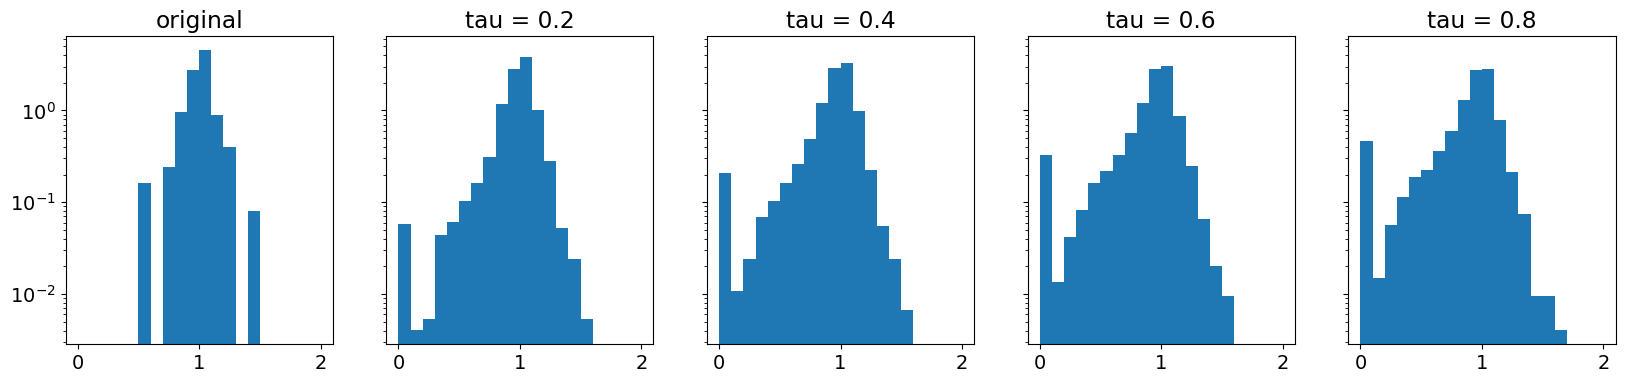

In [ ]:
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)

num_bins = 20

energy = E_orig.squeeze() / (X_norm_orig.squeeze()**2 + 1e-9)
axs[0].hist(energy, density=True, bins=num_bins, range=(0, 2))
axs[0].set_title(f'original')
axs[0].set_yscale('log')

for i in range(4):
    energy = E_rec[:, :, i].flatten() / (X_norm_rec[:, :, i].flatten()**2 + 1e-9)
    axs[i+1].hist(energy, density=True, bins=num_bins, range=(0,2))
    axs[i+1].set_title(f'tau = {T_lst[i]:.1f}')
    axs[i+1].set_yscale('log')

Differences in energies:

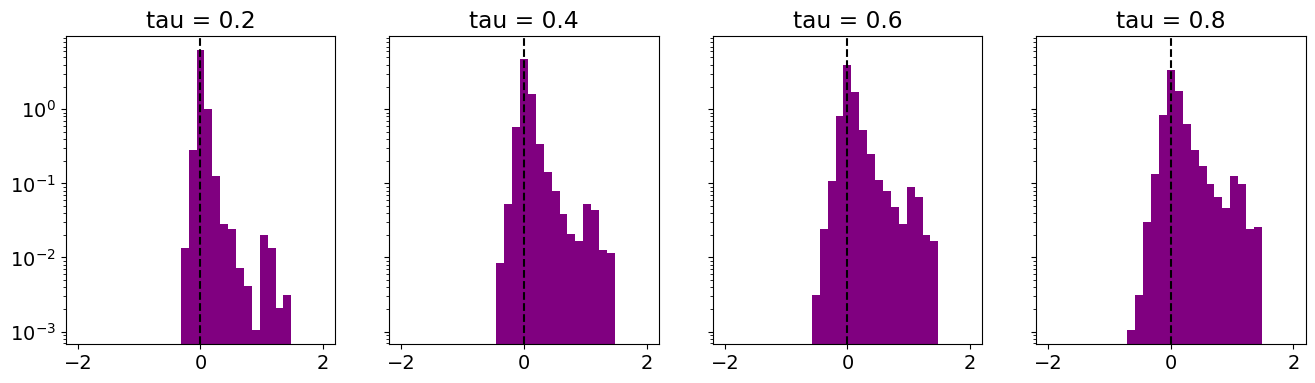

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True, sharex=True)

num_bins = 31

for i in range(4):
    diff = (E_orig[:,0] / (X_norm_orig[:,0]**2 + 1e-9) - E_rec[:, :, i] / (X_norm_rec[:, :, i]**2 + 1e-9)).flatten()
    axs[i].hist(diff, density=True, bins=num_bins, range=(-2, 2), color='purple')
    axs[i].axvline(x=0, linestyle='--', color='black')
    axs[i].set_title(f'tau = {T_lst[i]:.1f}')
    axs[i].set_yscale('log')